In [1]:
# Add path to src/CARPy, in case notebook is running locally
import os, sys, warnings
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..\\..\\..\\..\\src")))
warnings.simplefilter("ignore")  # <-- Suppress warnings

# FX 76-MP-140

## Geometry

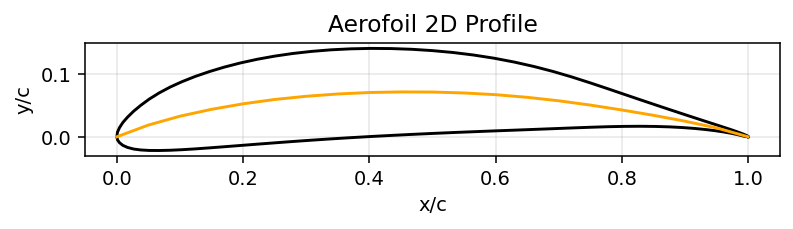

In [2]:
from carpy import geometry

fx76mp140 = geometry.NewAerofoil.from_url("http://airfoiltools.com/airfoil/lednicerdatfile?airfoil=fx76mp140-il")
fx76mp140.show()

### Real Wing

The actual section in the tunnel

In [3]:
from carpy.utility import Quantity

section = geometry.WingSection(fx76mp140)
section.chord = Quantity(50, "cm")

wing = geometry.WingSections(b=Quantity(1.6, "m"))
wing[0] = section
wing[1] = section

The section of wing in the wind tunnel has the following aspect ratio

In [4]:
wing.AR

3.2

### 2D Wing

For computation reasons, this is the effective wing

In [5]:
section = geometry.WingSection(fx76mp140)
section.chord = Quantity(50, "cm")

wing2d = geometry.WingSections(b=4)
wing2d[0] = section
wing2d[1] = section

The walls of the tunnel behave like winglet/end plates that impair lower-to-upper surface pressure equalisation.
For computations, the effective aspect ratio of the wing has become

In [6]:
wing2d.AR

8.0

## Performance

### Environment

Reynolds number of interest

In [7]:
from carpy.environment import ISA1975

atm = ISA1975()

altitude_m = 0
rho = atm.rho(altitude_m)
V = Quantity(10, "m s^{-1}")
L = Quantity(1, "m")
mu = atm.mu_visc(altitude_m)
Re = rho * V * L / mu

print(Re)

684582.81579933 


### Drag Prediction

In [8]:
from carpy.aerodynamics import MixedBLDrag
from carpy.utility import constants as co

CDf_wt = 0.70
CDf_CD0 = (CDf_wt / (1 - CDf_wt))

# Even though the surface was covered in Mylar, treat the
# wing surface as if it was turbulent, riveted steel
soln_zl = MixedBLDrag(
    wing2d, TAS=18,
    Ks=co.MATERIAL.roughness_Ks.steel_riveted.max(),
    CDf_CD0=CDf_CD0, Xtr_C=0
)
print(soln_zl)

** <carpy WingSections at 0x1d8c9a835b0> **
 CD  =  0.045273    CY  =       NAN    CL  =       NAN
 CD0 =  0.013582    CDf =  0.031691    CDi =       NAN
 CDw =       NAN    CDm =       NAN
 Cl  =       NAN    Cm  =       NAN    Cn  =       NAN
 Cli =       NAN    Cmi =       NAN    Cni =       NAN


### Experiments

In [9]:
import pandas as pd

dfs = {"Run 1": None, "Run 2": None, "Run 3": None}

for key in dfs:
    # Use special encoding that supports temperature column (T <ordinal indicator> C)
    dfs[key] = pd.read_csv(f"./FX 76-MP-140 Dec 2023 {key}.csv", encoding="ISO-8859-1")

Take a look at lift and drag polars

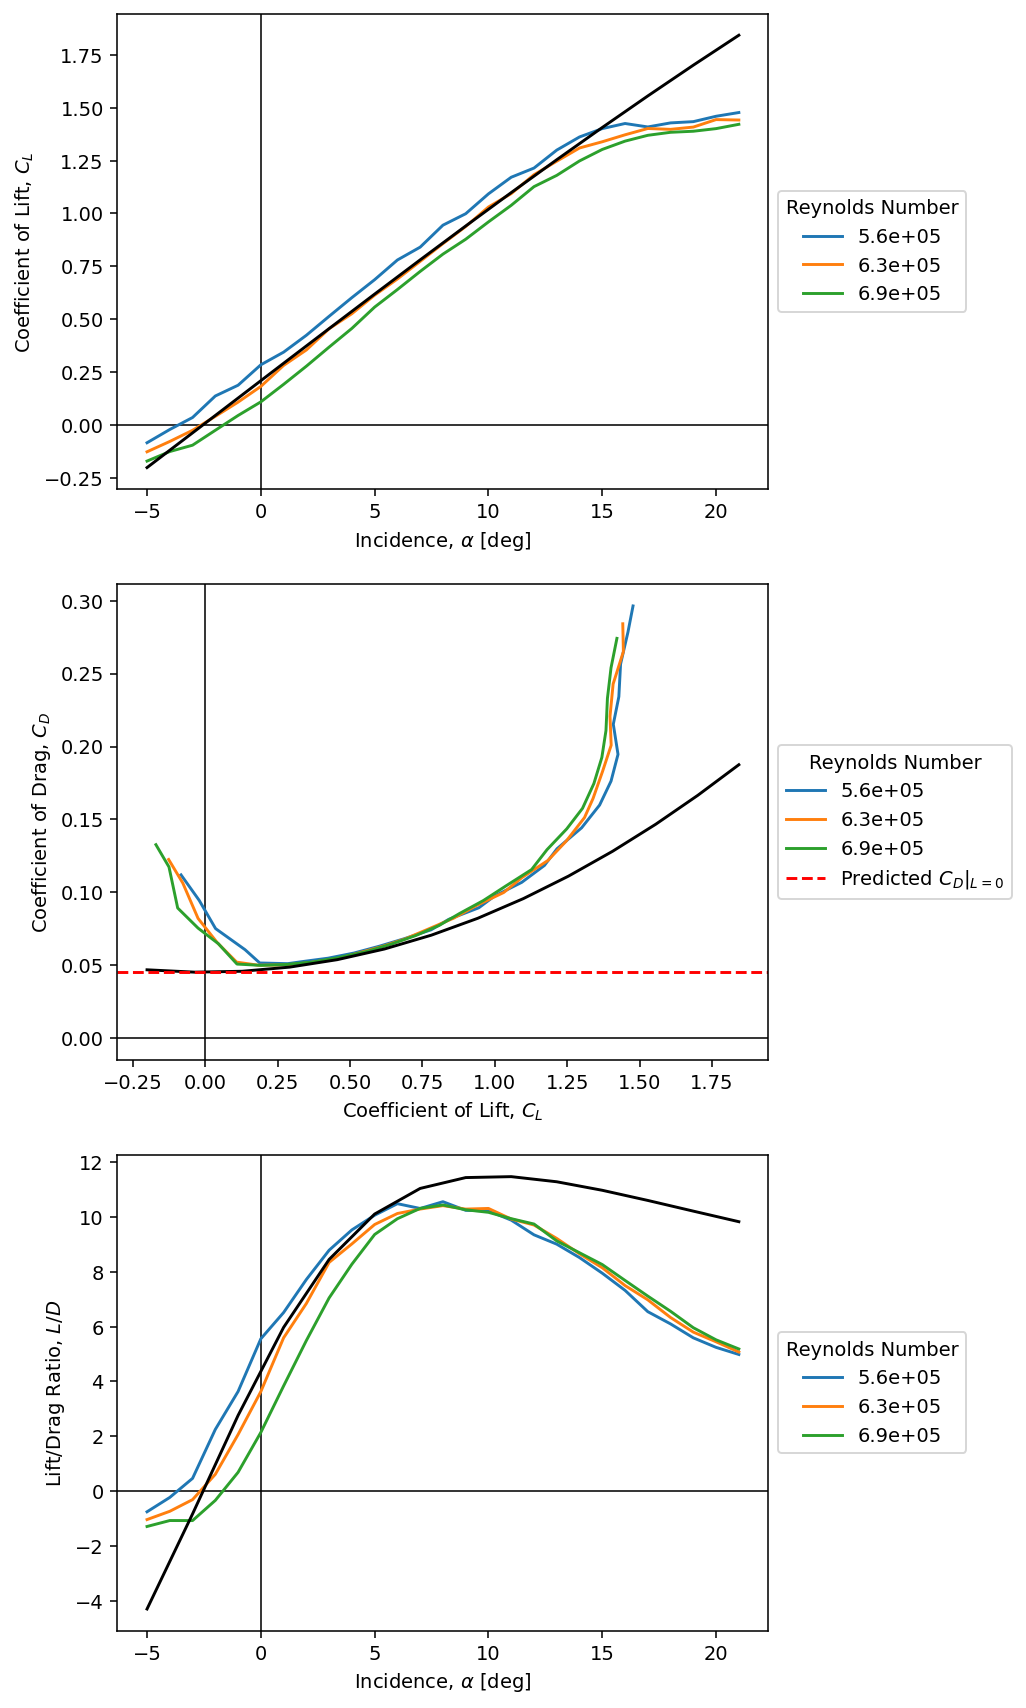

In [10]:
from matplotlib import pyplot as plt
import numpy as np
from carpy.aerodynamics import HorseshoeVortex

fig, axs = plt.subplots(3, 1, dpi=140, figsize=(6, 15))

for run_name, df in dfs.items():

    # Ignore any data points where the wind is off.
    df = df[~df["Comment"].fillna("").str.contains("Wind off")]
    df = df.dropna(axis=0, how="all")  # Drop empty rows

    lift_tunnel = -df["Lift"]
    drag_tunnel = df["Drag"]
    alpha = df["Incidence"]

    # Incase the lift and drag numbers from the tunnel aren't oriented with the wing chord
    orientation = 0
    lift = lift_tunnel * np.cos(orientation) - drag_tunnel * np.sin(orientation)
    drag = drag_tunnel * np.cos(orientation) + lift_tunnel * np.sin(orientation)
    
    q = df["DynPr Pa"]
    V = df["Wind m/s"]
    T = Quantity(df["T ºC"], "degC")
    
    # Sutherland's law of kinematic viscosity
    mu = co.STANDARD.ISO_2533.betaS * T ** 1.5
    mu = mu / (T + co.STANDARD.ISO_2533.S)
    
    rho = q / (0.5 * V ** 2)
    Re = rho * V * section.chord / mu
    label = f"{Re.mean():.2g}"
    
    cl = lift / (q * wing.Sref)
    cd = drag / (q * wing.Sref)

    # Lift-curve slope
    axs[0].plot(alpha, cl, label=label)
    axs[0].set_xlabel("Incidence, $\\alpha$ [deg]")
    axs[0].set_ylabel("Coefficient of Lift, $C_L$")

    # Drag polar
    axs[1].plot(cl, cd, label=label)
    axs[1].set_xlabel("Coefficient of Lift, $C_L$")
    axs[1].set_ylabel("Coefficient of Drag, $C_D$")

    # Lift/drag vs incidence
    axs[2].plot(alpha, cl/cd, label=label)
    axs[2].set_xlabel("Incidence, $\\alpha$ [deg]")
    axs[2].set_ylabel("Lift/Drag Ratio, $L/D$")

# Compute results
CLs = []
CDs = []
offset_deg = 5.5  # The computed zero-lift is this many degrees off the experimental zero-lift
alphas = np.arange(-5, 23, 2)

for alpha in alphas:
    print(f"Computing {alpha=: >3.0f} [deg]  ", end="\r")
    
    alpha_rad = np.radians(alpha-offset_deg)
    soln = soln_zl + HorseshoeVortex(wing2d, TAS=18, alpha=alpha_rad)
    CLs.append(soln.CL)
    CDs.append(soln.CD)

axs[0].plot(alphas, CLs, c="k")
axs[1].plot(CLs, CDs, c="k")
axs[1].axhline(soln_zl.CD, c="r", ls="--", label="Predicted $C_D|_{L=0}$")
axs[2].plot(alphas, [CLs[i] / CDs[i] for i in range(len(alphas))], c="k");

for ax in axs:
    ax.legend(bbox_to_anchor=(1, 0.5), loc="center left", title="Reynolds Number")
    ax.axhline(0, c="k", zorder=-10, lw=0.8)
    ax.axvline(0, c="k", zorder=-10, lw=0.8)

1. The computer model does not account for increasing separation drag at higher AoA, where the wing would begin to stall.
2. The computer model does not correctly compute zero-lift drag of this aerofoil.
   An offset of 5.5 degrees was discovered through trial-and-error.
4. The drag rise in experimental results near $C_L=0$ may indicate separation.
   If we imagine a world without separation, the experimental drag coefficient at zero lift is $C_D|_{L=0} \approx 0.05$.
   This is very high - even when we assume a fully turbulent flow (and surface roughness of riveted steel), the predicted solution had to assume that skin friction was only 70% of the section's minimum drag and the remaining 30% is pressure drag (presumably attributed to separation and poor surface quality/finish).
   This is the opposite of what would be expected in a well designed and built aircraft, in that ~85% of drag should come from skin friction effects, and ~15% from pressure drag losses.
   Either the wind tunnel test sesction has poor real-world characteristics, or the skin friction drag prediction is wishful thinking.